In [1]:
import kagglehub

# This will download into the default KaggleHub cache (under /root/.cache/kagglehub)
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

# Move the dataset to /content
import shutil
import os

# Get the folder name from the path
folder_name = os.path.basename(path)
target_path = f"/content/{folder_name}"

# Copy to /content
shutil.copytree(path, target_path, dirs_exist_ok=True)

print("Dataset copied to:", target_path)


Dataset copied to: /content/vegetable-image-dataset


In [2]:
import os

def count_files_in_directory(directory):
    print(f"📂 Root Directory: {directory}")
    total_files = 0

    for root, dirs, files in os.walk(directory):
        # Get subfolder path relative to root
        relative_path = os.path.relpath(root, directory)
        relative_path = "." if relative_path == "." else f"./{relative_path}"

        file_count = len(files)
        total_files += file_count

        print(f"{relative_path} - {file_count} file(s)")

    print(f"\n📊 Total files in '{directory}': {total_files}")

# Example usage
count_files_in_directory("/content/vegetable-image-dataset/Vegetable Images")


📂 Root Directory: /content/vegetable-image-dataset/Vegetable Images
. - 0 file(s)
./train - 0 file(s)
./train/Carrot - 1000 file(s)
./train/Cabbage - 1000 file(s)
./train/Bitter_Gourd - 1000 file(s)
./train/Bean - 1000 file(s)
./train/Radish - 1000 file(s)
./train/Pumpkin - 1000 file(s)
./train/Brinjal - 1000 file(s)
./train/Cucumber - 1000 file(s)
./train/Tomato - 1000 file(s)
./train/Bottle_Gourd - 1000 file(s)
./train/Papaya - 1000 file(s)
./train/Cauliflower - 1000 file(s)
./train/Broccoli - 1000 file(s)
./train/Capsicum - 1000 file(s)
./train/Potato - 1000 file(s)
./test - 0 file(s)
./test/Carrot - 200 file(s)
./test/Cabbage - 200 file(s)
./test/Bitter_Gourd - 200 file(s)
./test/Bean - 200 file(s)
./test/Radish - 200 file(s)
./test/Pumpkin - 200 file(s)
./test/Brinjal - 200 file(s)
./test/Cucumber - 200 file(s)
./test/Tomato - 200 file(s)
./test/Bottle_Gourd - 200 file(s)
./test/Papaya - 200 file(s)
./test/Cauliflower - 200 file(s)
./test/Broccoli - 200 file(s)
./test/Capsicum - 2

In [3]:
import csv

data = [
    ["Split", "Class", "Image Count"],
]

# Recounting using os.walk to populate CSV
root_dir = "/content/vegetable-image-dataset/Vegetable Images"


for root, dirs, files in os.walk(root_dir):
    if files:
        cls = os.path.basename(root)
        split = os.path.basename(os.path.dirname(root))
        data.append([split, cls, len(files)])

# Write to CSV
with open("dataset_summary.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data)

print("✅ CSV summary saved as 'dataset_summary.csv'")


✅ CSV summary saved as 'dataset_summary.csv'


In [4]:
import pandas as pd
df = pd.read_csv('dataset_summary.csv')

In [5]:
df.head()

,Split,Class,Image Count
0,train,Carrot,1000
1,train,Cabbage,1000
2,train,Bitter_Gourd,1000
3,train,Bean,1000
4,train,Radish,1000


In [6]:
df.Class.value_counts()

,count
Class,
Carrot,3
Cabbage,3
Bitter_Gourd,3
Bean,3
Radish,3
Pumpkin,3
Brinjal,3
Cucumber,3
Tomato,3


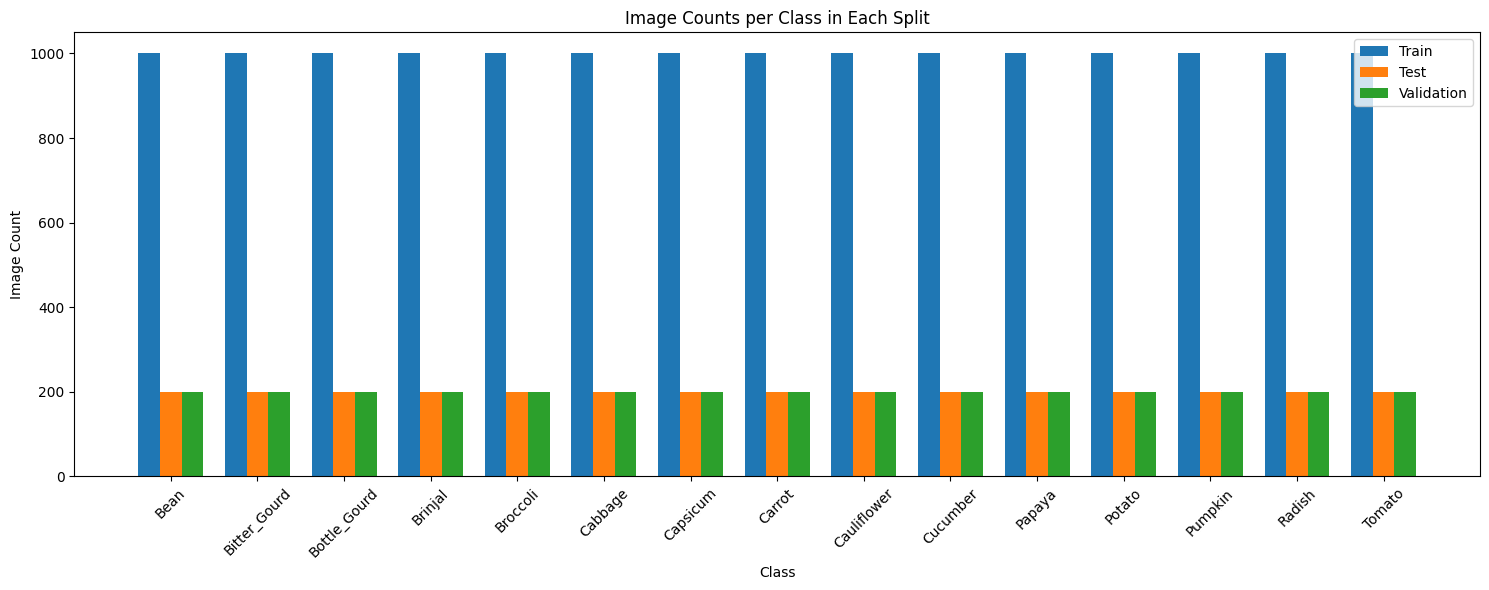

In [1]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Directory path
base_path = "/content/vegetable-image-dataset/Vegetable Images"

# Count images per class in each split
counts = defaultdict(lambda: defaultdict(int))

for split in ['train', 'test', 'validation']:
    split_path = os.path.join(base_path, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            counts[split][class_name] = len(os.listdir(class_path))

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
classes = sorted(list(counts['train'].keys()))
x = range(len(classes))

train_counts = [counts['train'][cls] for cls in classes]
test_counts = [counts['test'][cls] for cls in classes]
val_counts = [counts['validation'][cls] for cls in classes]

ax.bar(x, train_counts, width=bar_width, label='Train')
ax.bar([i + bar_width for i in x], test_counts, width=bar_width, label='Test')
ax.bar([i + 2*bar_width for i in x], val_counts, width=bar_width, label='Validation')

ax.set_xlabel("Class")
ax.set_ylabel("Image Count")
ax.set_title("Image Counts per Class in Each Split")
ax.set_xticks([i + bar_width for i in x])
ax.set_xticklabels(classes, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [2]:
from PIL import Image

def check_corrupted_images(folder_path):
    corrupted = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Check for corruption
            except (IOError, SyntaxError) as e:
                corrupted.append(file_path)

    return corrupted

# Run the check
corrupted_files = check_corrupted_images("/content/1/Vegetable Images")

# Results
if corrupted_files:
    print(f"❌ Found {len(corrupted_files)} corrupted image(s):")
    for path in corrupted_files:
        print(path)
else:
    print("✅ All images are valid.")


✅ All images are valid.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Config
data_dir = "/content/vegetable-image-dataset/Vegetable Images"
IMG_SIZE = (128, 128)
BATCH_SIZE = 16  # Lower batch size for stability

# Load datasets
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "validation"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)

# Optimize datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.prefetch(buffer_size=AUTOTUNE)

# ✅ Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])



Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [15]:

# ✅ Model with dropout + augmentation
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(NUM_CLASSES)
])


In [16]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
# ✅ Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ✅ Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    #callbacks=[early_stop]
)


Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.8138 - loss: 0.5712 - val_accuracy: 0.8577 - val_loss: 0.4930
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.8149 - loss: 0.5620 - val_accuracy: 0.8663 - val_loss: 0.4535
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.8359 - loss: 0.5176 - val_accuracy: 0.8703 - val_loss: 0.4792
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8408 - loss: 0.4813 - val_accuracy: 0.8913 - val_loss: 0.3558
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.8439 - loss: 0.4805 - val_accuracy: 0.8963 - val_loss: 0.3789
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8534 - loss: 0.4554 - val_accuracy: 0.9297 - val_loss: 0.2668
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8590 - loss: 0.4328 - val_accuracy: 0.9113 - val_loss: 0.3153
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.8598 - loss: 0.4351 - 

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,394,255 (28.21 MB)

 Trainable params: 7,394,255 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

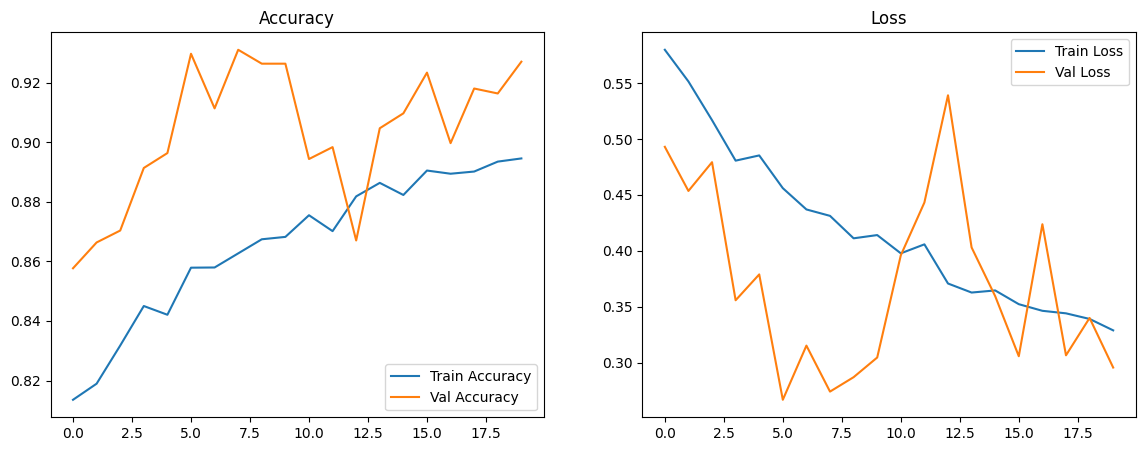

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [23]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf

# Ensure this is the same order as during training
class_names = raw_val_ds.class_names

# Step 1: Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in raw_val_ds:
    logits = model.predict(images, verbose=0)
    predictions = tf.argmax(logits, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predictions.numpy())

# Step 2: Classification report
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


              precision    recall  f1-score   support

        Bean     0.8889    0.9200    0.9042       200
Bitter_Gourd     0.8622    0.9700    0.9129       200
Bottle_Gourd     0.9688    0.9300    0.9490       200
     Brinjal     0.9297    0.8600    0.8935       200
    Broccoli     0.8479    0.9200    0.8825       200
     Cabbage     0.8929    0.8750    0.8838       200
    Capsicum     0.9896    0.9500    0.9694       200
      Carrot     0.9804    1.0000    0.9901       200
 Cauliflower     0.8630    0.9450    0.9021       200
    Cucumber     0.9343    0.9250    0.9296       200
      Papaya     0.9581    0.9150    0.9361       200
      Potato     0.9752    0.9850    0.9801       200
     Pumpkin     0.9474    0.9000    0.9231       200
      Radish     0.9695    0.9550    0.9622       200
      Tomato     0.9243    0.8550    0.8883       200

    accuracy                         0.9270      3000
   macro avg     0.9288    0.9270    0.9271      3000
weighted avg     0.9288   

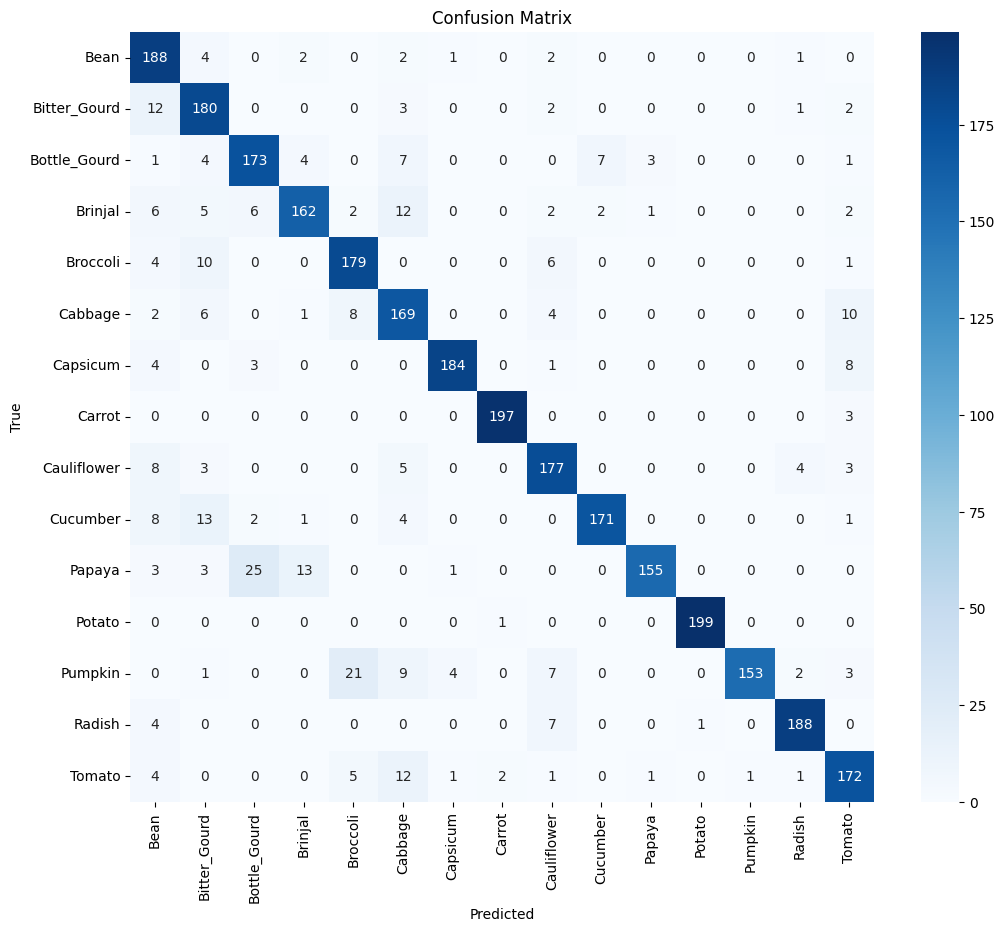

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
